In [115]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import os

In [116]:
# Data import
index_df = yf.download (tickers = "^GSPC ^FTSE ^HSI ^N225 000001.SS ^SSMI ^GDAXI ^FCHI", start = "1930-1-1",
                              end = "2023-8-31", interval = "1d")
index_df.replace(0, np.nan, inplace=True)
print(index_df)

[*********************100%***********************]  8 of 8 completed
              Adj Close                                                       \
              000001.SS        ^FCHI        ^FTSE        ^GDAXI        ^GSPC   
Date                                                                           
1930-01-02          NaN          NaN          NaN           NaN    21.180000   
1930-01-03          NaN          NaN          NaN           NaN    21.230000   
1930-01-06          NaN          NaN          NaN           NaN    21.500000   
1930-01-07          NaN          NaN          NaN           NaN    21.309999   
1930-01-08          NaN          NaN          NaN           NaN    21.290001   
...                 ...          ...          ...           ...          ...   
2023-08-24  3082.239990  7214.459961  7333.600098  15621.490234  4376.310059   
2023-08-25  3064.070068  7229.600098  7338.600098  15631.820312  4405.709961   
2023-08-28  3098.639893  7324.709961          NaN  

## Return

In [128]:
price_df = index_df['Adj Close'].dropna()
volume_df = index_df['Volume'].dropna()
volatility_df = price_df.rolling(window=252).std()

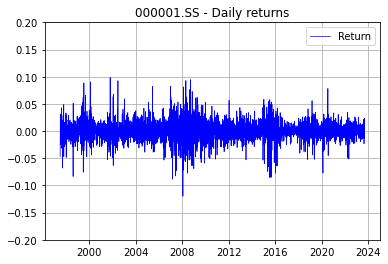

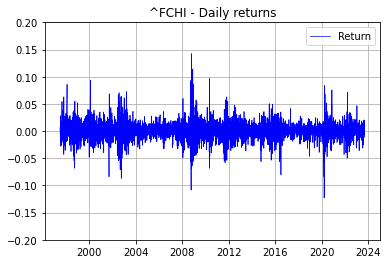

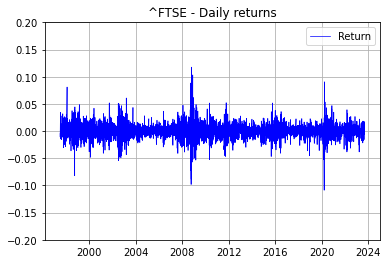

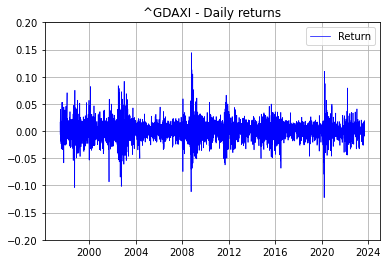

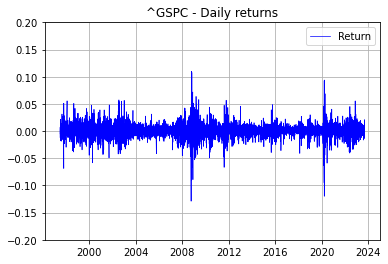

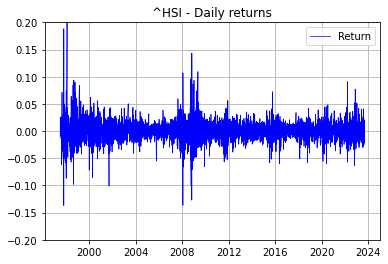

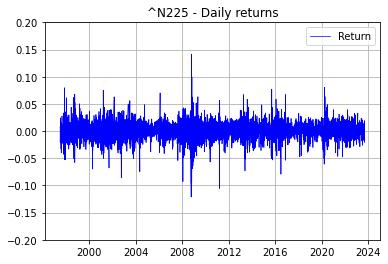

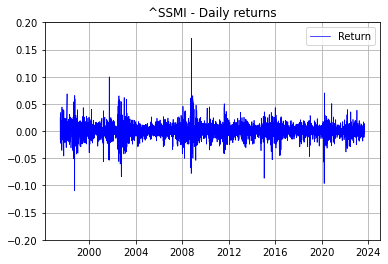

In [129]:
return_df = price_df.pct_change().dropna()
for index_name in return_df: 
    plt.plot(return_df[index_name], color='blue', linewidth=0.7)
    plt.ylim(-0.2, 0.2)
    plt.grid()
    plt.legend(['Return'])
    plt.title(index_name + ' - Daily returns')
    plt.show()

In [154]:
all_index_df = pd.DataFrame()
path = "./data/index/"

for index_name in price_df: 
    index_data_df = pd.concat([price_df[index_name].index.to_frame()['Date'], return_df[index_name], volume_df[index_name], volatility_df[index_name]], axis=1).dropna()
    index_data_df.columns=['date', 'price_change', 'volume', 'volatility']
    index_data_df.to_csv(path + f"{index_name}_index.csv", index=False)
    print(f"Saved {index_name}_index.csv")
    index_data_df['index'] = index_name
    all_index_df = pd.concat([all_index_df, index_data_df], ignore_index=True)
    

    
all_index_df.to_csv(path + f"all_index.csv", index=False)
print(f"Saved all_index.csv")
    

Saved 000001.SS_index.csv
Saved ^FCHI_index.csv
Saved ^FTSE_index.csv
Saved ^GDAXI_index.csv
Saved ^GSPC_index.csv
Saved ^HSI_index.csv
Saved ^N225_index.csv
Saved ^SSMI_index.csv
Saved all_index.csv


In [4]:
# Autocorrelation: daily return is not a strong predictor for the price change of the following day
for index_name in return_df:
    print(return_df[index_name].autocorr(lag=1))

0.010656509124401406
-0.010884652531489885
-0.0016711262069110079
-0.016289945112698365
-0.01737814342021477
-0.008046036822312568
-0.010419758350281484
0.02703440770157935


## Drawdown
def: total loss over consequtive days from the last maximum to the next minimum of the price

In [5]:
for index_name in index_df:
    print(index_df[index_name])

Date
1930-01-02            NaN
1930-01-03            NaN
1930-01-06            NaN
1930-01-07            NaN
1930-01-08            NaN
                 ...     
2023-08-24    3082.239990
2023-08-25    3064.070068
2023-08-28    3098.639893
2023-08-29    3135.889893
2023-08-30    3137.139893
Name: (Adj Close, 000001.SS), Length: 24020, dtype: float64
Date
1930-01-02            NaN
1930-01-03            NaN
1930-01-06            NaN
1930-01-07            NaN
1930-01-08            NaN
                 ...     
2023-08-24    7214.459961
2023-08-25    7229.600098
2023-08-28    7324.709961
2023-08-29    7373.430176
2023-08-30    7364.399902
Name: (Adj Close, ^FCHI), Length: 24020, dtype: float64
Date
1930-01-02            NaN
1930-01-03            NaN
1930-01-06            NaN
1930-01-07            NaN
1930-01-08            NaN
                 ...     
2023-08-24    7333.600098
2023-08-25    7338.600098
2023-08-28            NaN
2023-08-29    7465.000000
2023-08-30    7473.700195
Name: (Adj 

In [85]:
# M1: Consecutive dates

drawdowns_dict = {}
drawdowns_f = []
for index_name in index_df['Adj Close']:
    index_change = index_df['Adj Close'][index_name].diff()
    drawdowns = []
    drawdown_start = None
    dd = 0
    for date, price in index_df['Adj Close'][index_name].items():
        if drawdown_start is None and index_change[date] < 0:
            drawdown_start = date
            dd += index_change[date]
        elif drawdown_start is not None and index_change[date] <= 0:
            dd += index_change[date]
        elif drawdown_start is not None and index_change[date] > 0:
            drawdown_end = date
            duration = (drawdown_end - drawdown_start).days
            drawdown = dd / index_df['Adj Close'][index_name][drawdown_start]
            drawdowns.append((drawdown_start, drawdown_end, duration, drawdown))
            drawdown_start = None
            dd = 0

    # Convert drawdowns list to DataFrame
    drawdowns_df = pd.DataFrame(drawdowns, columns=['drawdown_start', 'drawdown_end', 'duration', 'drawdown'])
    drawdowns_df = drawdowns_df.sort_values(by='drawdown')
    drawdowns_dict[index_name] = drawdowns_df

print(drawdowns_dict)

{'000001.SS':      drawdown_start drawdown_end  duration  drawdown
1060     2015-08-20   2015-08-27         7 -0.236559
1052     2015-07-01   2015-07-06         5 -0.145622
1051     2015-06-25   2015-06-30         5 -0.140714
12       1997-09-22   1997-09-24         2 -0.129130
658      2008-10-21   2008-10-28         7 -0.127981
...             ...          ...       ...       ...
911      2012-12-19   2012-12-20         1 -0.000104
1132     2016-08-29   2016-08-30         1 -0.000092
1140     2016-10-20   2016-10-21         1 -0.000085
382      2004-02-19   2004-02-20         1 -0.000047
798      2011-02-25   2011-02-28         3 -0.000013

[1562 rows x 4 columns], '^FCHI':      drawdown_start drawdown_end  duration  drawdown
1898     2020-03-05   2020-03-13         8 -0.264989
748      2002-09-12   2002-09-25        13 -0.201802
1340     2011-07-25   2011-08-09        15 -0.188176
1166     2008-10-08   2008-10-13         5 -0.158921
734      2002-07-19   2002-07-25         6 -0.1474

## Crashes
- 99.5% percentile of drawdowns

In [77]:
# Crash Identification
crashes_dict = {}
for index, dd in drawdowns_dict.items():
    crash_threshold = dd['drawdown'].iloc[round(dd.shape[0] * 0.005)]
    crash_df = dd[dd['drawdown'] < crash_threshold]
    crash_df.columns = ['crash_start', 'crash_end', 'duration','drawdown']
    crashes_dict[index] = crash_df

print(crashes_dict)

{'000001.SS':      crash_start  crash_end  duration  drawdown
1060  2015-08-20 2015-08-27         7 -0.236559
1052  2015-07-01 2015-07-06         5 -0.145622
1051  2015-06-25 2015-06-30         5 -0.140714
12    1997-09-22 1997-09-24         2 -0.129130
658   2008-10-21 2008-10-28         7 -0.127981
612   2008-01-21 2008-01-23         2 -0.126314
621   2008-03-12 2008-03-19         7 -0.122105
227   2001-07-23 2001-08-01         9 -0.119551, '^FCHI':      crash_start  crash_end  duration  drawdown
1898  2020-03-05 2020-03-13         8 -0.264989
748   2002-09-12 2002-09-25        13 -0.201802
1340  2011-07-25 2011-08-09        15 -0.188176
1166  2008-10-08 2008-10-13         5 -0.158921
734   2002-07-19 2002-07-25         6 -0.147417
23    1990-08-10 1990-08-22        12 -0.137795
682   2001-09-05 2001-09-12         7 -0.134359
775   2003-03-04 2003-03-13         9 -0.134217
1167  2008-10-15 2008-10-17         2 -0.132360
1115  2008-01-15 2008-01-22         7 -0.125516
1618  2015-08-18

In [155]:
# Save crashes to csv 
all_crashes_df = pd.DataFrame()
path = "./data/crashes/"
for index, crashes_df in crashes_dict.items():
    crashes_df.to_csv(path + f"{index}_crahes.csv", index=False)
    print(f"Saved {index}_crashes.csv")
    crashes_df['index'] = index
    all_crashes_df = pd.concat([all_crashes_df, crashes_df], ignore_index=True)
    
all_crashes_df.to_csv(path + f"all_crashes.csv", index=False)
print(f"Saved all_crashes.csv")

Saved 000001.SS_crashes.csv
Saved ^FCHI_crashes.csv
Saved ^FTSE_crashes.csv
Saved ^GDAXI_crashes.csv
Saved ^GSPC_crashes.csv
Saved ^HSI_crashes.csv
Saved ^N225_crashes.csv
Saved ^SSMI_crashes.csv
Saved all_crashes.csv


/var/folders/9r/7ktg2zxx2gs716xfvv5vjjpc0000gn/T/ipykernel_12203/3072608851.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crashes_df['index'] = index


In [156]:
# Crashes Count
crash_count = 0
for index, crashes_df in crashes.items():
    crash_count += len(crashes_df)
print(crash_count)

107


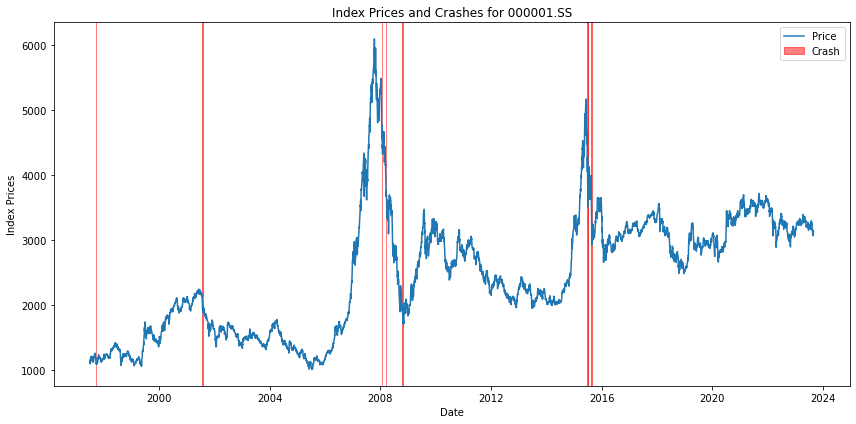

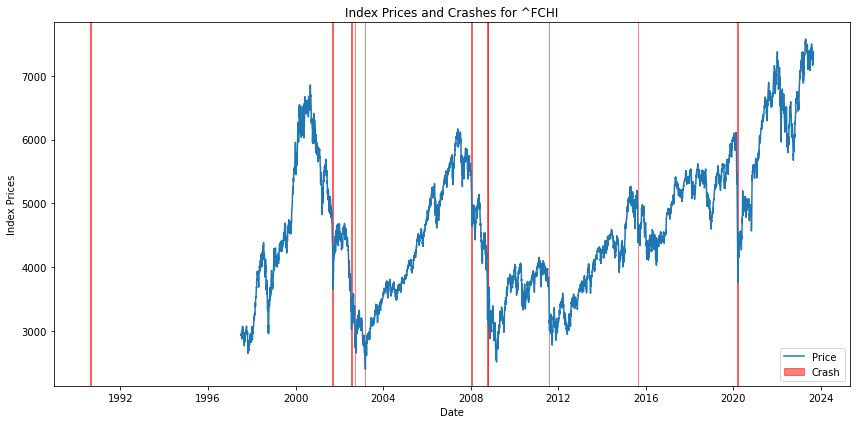

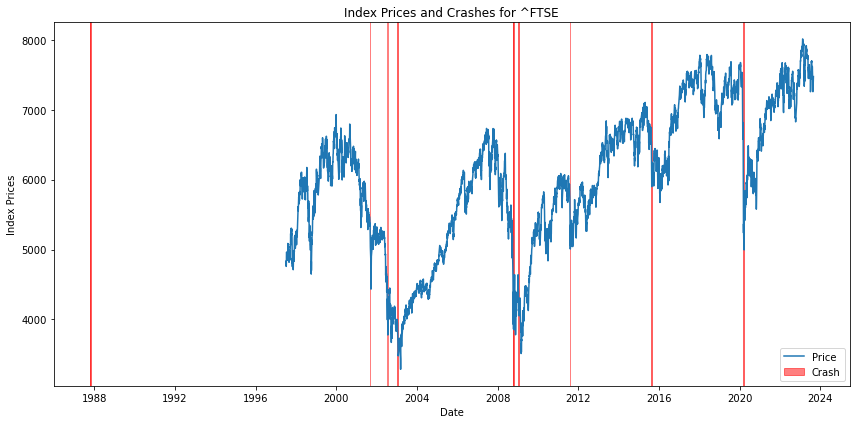

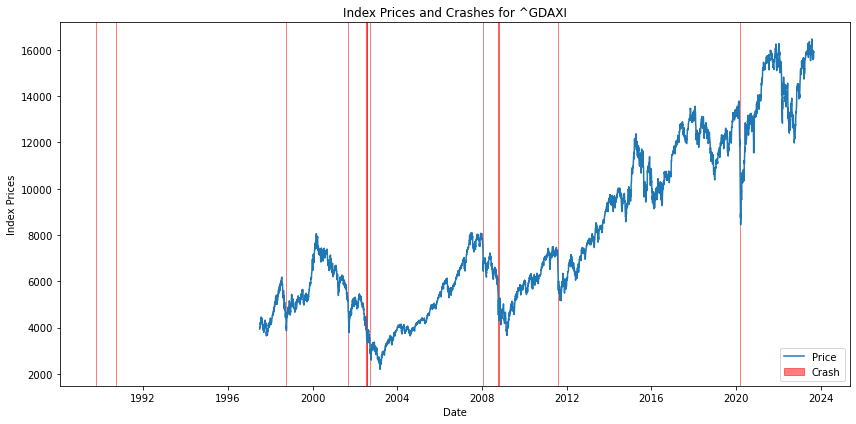

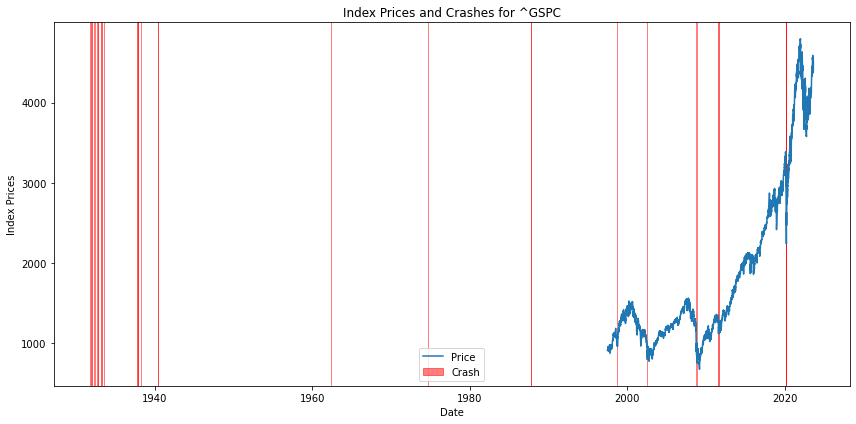

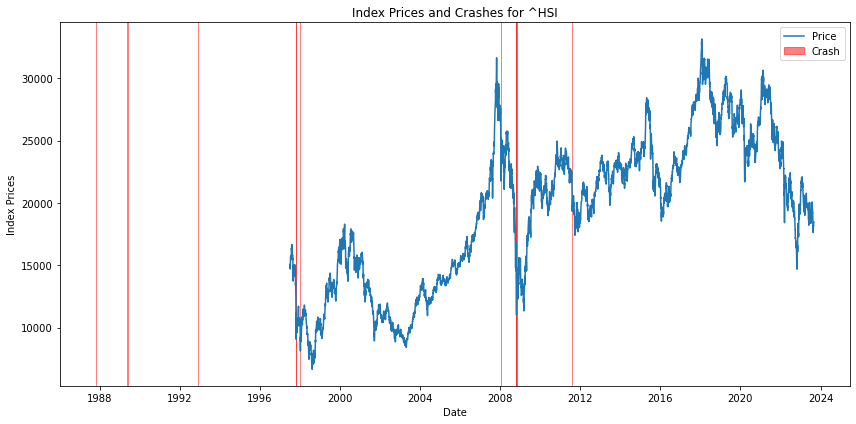

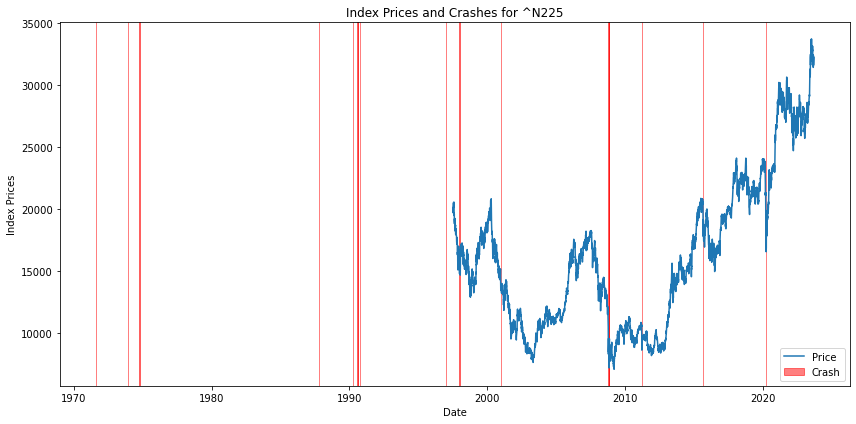

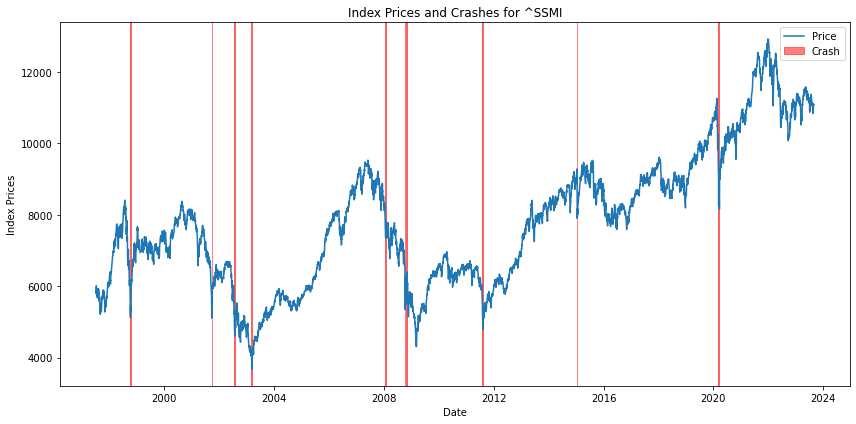

In [157]:
# Plot crashes in graph
# noise in S&P?
for index, crashes_df in crashes_dict.items():
    index_prices = np.array(price_df[index])
    index_dates = np.array(price_df.index)
    plt.figure(figsize=(12, 6))
    plt.plot(index_dates, index_prices, label=f'{index} Prices')
    for crash_start, crash_end in zip(crashes_df['crash_start'], crashes_df['crash_end']):
        plt.axvspan(crash_start, crash_end, alpha=0.5, color='red')
    plt.title(f'Index Prices and Crashes for {index}')
    plt.xlabel('Date')
    plt.ylabel('Index Prices')
    plt.legend(['Price', 'Crash'])
    plt.tight_layout()
    plt.show()

## Label the crashes
- we need to label the crashes to each day using all_index_df and all_crashes_df before training them to ML models

In [188]:
# Convert 'crash_start' and 'crash_end' to datetime objects
all_crashes_df['crash_start'] = pd.to_datetime(all_crashes_df['crash_start'])
all_crashes_df['crash_end'] = pd.to_datetime(all_crashes_df['crash_end'])

# Convert 'Date' to datetime objects
all_index_df['date'] = pd.to_datetime(all_index_df['date'])


In [189]:
# Function to label crashes
def label_crashes(row):
    for index, crash in all_crashes_df.iterrows():
        if crash['crash_start'] <= row['date'] and row['date'] <= crash['crash_end'] and row['index'] == crash['index']:
            return 1
    return 0

# Apply the function to create a new column indicating whether there was a crash
all_index_df['crash_label'] = all_index_df.apply(label_crashes, axis=1)

In [179]:
# View the resulting dataframe
all_index_df

,date,price_change,volume,volatility,index,crash_label
0,2004-10-12,-0.027050,17000.0,133.040126,000001.SS,0
1,2004-10-13,0.001648,14200.0,133.199115,000001.SS,0
2,2004-10-14,-0.038784,17200.0,133.564172,000001.SS,0
3,2004-10-15,-0.001816,13600.0,133.936888,000001.SS,0
4,2004-10-18,0.003665,10200.0,134.283347,000001.SS,0
...,...,...,...,...,...,...
31475,2023-08-23,0.009007,19656100.0,294.518462,^SSMI,0
31476,2023-08-24,0.000291,24410000.0,294.231759,^SSMI,0
31477,2023-08-25,-0.001816,18229100.0,294.159642,^SSMI,0
31478,2023-08-29,0.013630,20434600.0,293.834079,^SSMI,0


In [173]:
# Save as csv
labeled_index = all_index_df
labeled_index.to_csv('./data/index/' + f"labeled_index.csv", index=False)
print(f"Saved labeled_index.csv")

Saved labeled_index.csv


## Dataset imbalances

The rare nature of stock market crash events results in a highly imbalanced dataset. 
Only 0.7% of available sample corresponds to crash events. Imbalanced dataset can influence ML algorithms and biased against the minority class<br>
One of the solutions is apply resampling

In [190]:
print("Total sample size: ", len(all_index_df))
print("Sample size of not crash: ", all_index_df['crash_label'].value_counts()[0])
print("Sample size of crash: ", all_index_df['crash_label'].value_counts()[1])
print("Percentage of crash: ", all_index_df['crash_label'].value_counts()[1]/len(all_index_df))

Total sample size:  31480
Sample size of not crash:  31239
Sample size of crash:  241
Percentage of crash:  0.007655654383735705
